# Stock selection strategy
## Model
y: N 天后的股价

a: 起始股价

m: 0-1.1 之间的一个数，需要根据历史数据估计

以下是我们的模型：
$$ y = m^{N}*a $$

两边取对数：
$$ \log(y) = N \log(m) + \log(a) $$

令 $\log(y) = \mathcal{Y}$, $\log(m) = b$, $\log(a) = c$，我们得到：
$$ \mathcal{Y} = N b + c $$

这是一个线性方程，我们可以使用线性回归来估计参数 $b$ 和 $c$。


 接下来我们去最近的一只强势个股 *深圳华强* 进行验证。

In [6]:
# import necessary packages
import numpy as np
import pandas as pd
import qstock as qs
import matplotlib.pyplot as plt
import mplfinance as mpl
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
from tqdm import tqdm

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC', 'SimHei', 'Arial Unicode MS', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

深圳华强的股票代码是: 603883


        date name    code   open   high    low  close  volume     turnover  \
0 2024-06-28  老百姓  603883  19.19  19.29  18.20  18.36  168986  314002699.0   
1 2024-07-01  老百姓  603883  18.36  19.29  18.14  19.18  161775  302822106.0   
2 2024-07-02  老百姓  603883  19.03  19.45  18.78  18.95  121984  232268870.0   
3 2024-07-03  老百姓  603883  18.98  18.98  17.96  18.06  117766  215463298.0   
4 2024-07-04  老百姓  603883  18.01  18.10  17.51  17.64   92163  163080305.0   

   turnover_rate  
0           2.23  
1           2.13  
2           1.61  
3           1.55  
4           1.22  


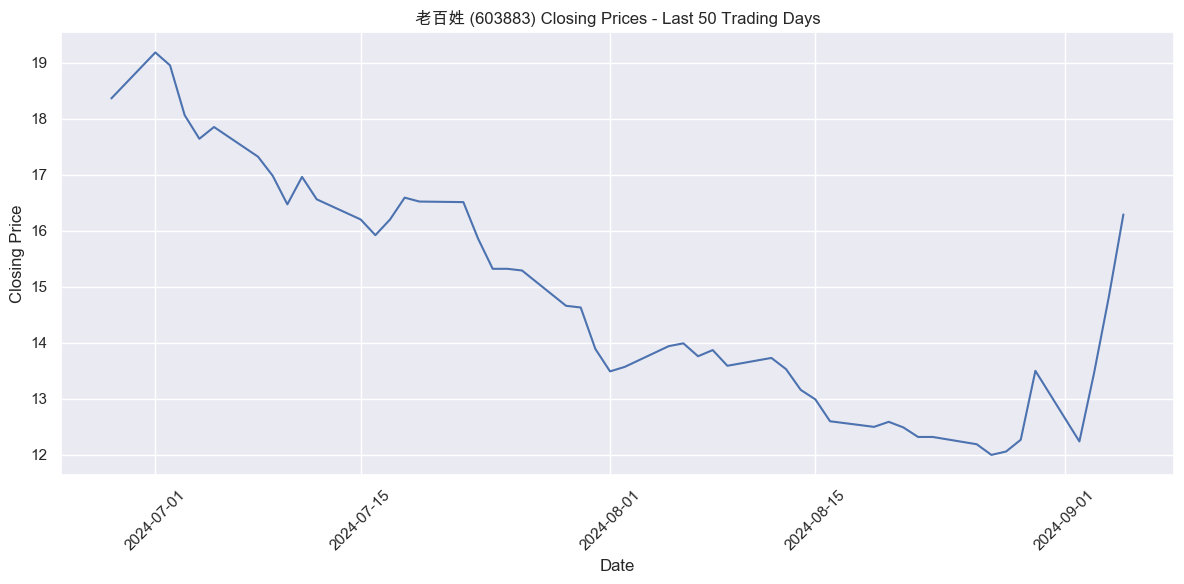

In [20]:
# First, let's find the stock code for 深圳华强
stock_name = '老百姓'
stock_list = qs.realtime_data()
stock_info = stock_list[stock_list['名称'] == stock_name]

if stock_info.empty:
    print(f"股票 '{stock_name}' 未找到。")
else:
    stock_code = stock_info.iloc[0]['代码']
    print(f"深圳华强的股票代码是: {stock_code}")

    # Get the stock data for 深圳华强 for the last 50 trading days
    end_date = pd.Timestamp.today().strftime('%Y%m%d')
    start_date = (pd.Timestamp.today() - pd.Timedelta(days=100)).strftime('%Y%m%d')

    # Fetch the data using qstock
    df = qs.get_data(stock_code, start=start_date, end=end_date)

    # Keep only the last 50 rows
    df = df.tail(50)

    # Reset the index to make the date a column
    df = df.reset_index()

    # Display the first few rows of the data
    print(df.head())

    # Plot the closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['close'])
    plt.title(f'{stock_name} ({stock_code}) Closing Prices - Last 50 Trading Days')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



# 计算最近N天的参数b和预测未来收益

估计的参数b（log(m)）: -0.001470
估计的参数c（log(a)）: 2.598962
估计的参数m: 0.998531
R^2值: 0.0271
1天后的预测收益率: -8.26% (原始: -20.65%)
3天后的预测收益率: -8.35% (原始: -20.88%)
5天后的预测收益率: -8.45% (原始: -21.11%)
模型拟合度较低，预测结果可能不太可靠。


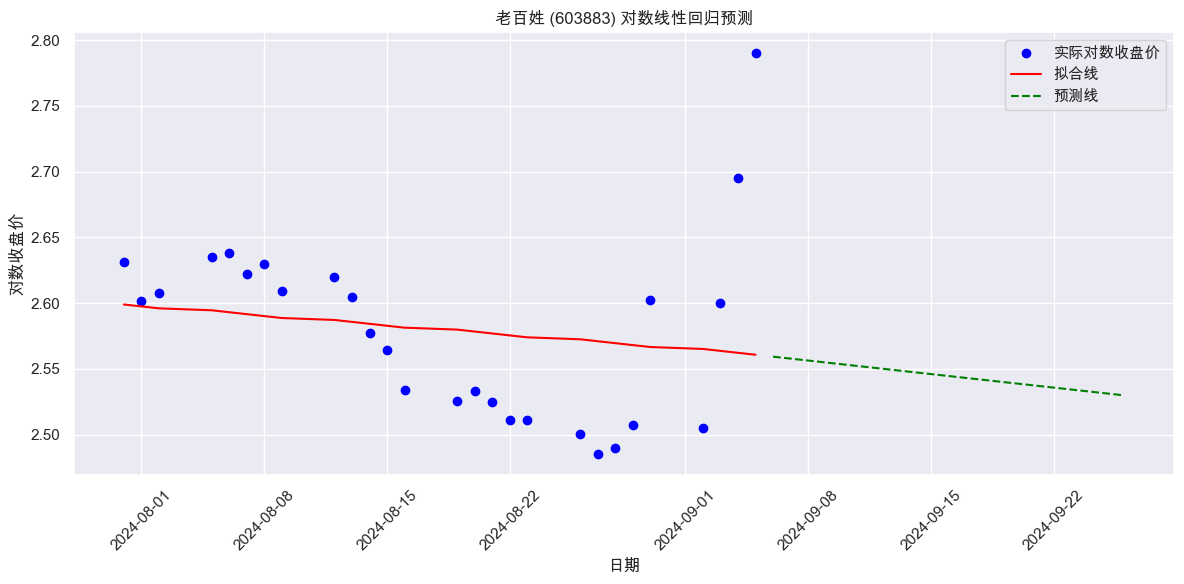

In [21]:
# 计算最近N天的参数b和预测未来收益

N = 27

if len(df) >= N:
    # 取最近N天的数据
    recent_data = df.tail(N).copy()
    
    # 创建特征（时间）和目标（收盘价的对数）
    X = np.arange(N).reshape(-1, 1)
    y = np.log(recent_data['close'].values)
    
    # 使用线性回归拟合数据
    model = LinearRegression()
    model.fit(X, y)
    
    # 获取参数b（斜率）和c（截距）
    b = model.coef_[0]
    c = model.intercept_
    
    print(f"估计的参数b（log(m)）: {b:.6f}")
    print(f"估计的参数c（log(a)）: {c:.6f}")
    
    # 计算m
    m = np.exp(b)
    print(f"估计的参数m: {m:.6f}")
    
    # 计算R^2值
    r_squared = model.score(X, y)
    print(f"R^2值: {r_squared:.4f}")

    # 预测未来7天、14天和21天的收益
    future_days = [1, 3, 5]
    last_price = recent_data['close'].iloc[-1]
    
    for days in future_days:
        future_log_price = model.predict([[N - 1 + days]])[0]
        future_price = np.exp(future_log_price)
        raw_returns = (future_price - last_price) / last_price * 100
        
        # 根据R^2值修正收益率
        if r_squared > 0.8:
            adjusted_returns = raw_returns
        elif r_squared > 0.6:
            adjusted_returns = raw_returns * 0.8
        elif r_squared > 0.4:
            adjusted_returns = raw_returns * 0.6
        else:
            adjusted_returns = raw_returns * 0.4
        
        print(f"{days}天后的预测收益率: {adjusted_returns:.2f}% (原始: {raw_returns:.2f}%)")

    # 解释R^2值
    if r_squared > 0.8:
        print("模型拟合度很高，预测可能比较可靠。")
    elif r_squared > 0.6:
        print("模型拟合度良好，预测可能有一定参考价值。")
    elif r_squared > 0.4:
        print("模型拟合度一般，预测结果请谨慎参考。")
    else:
        print("模型拟合度较低，预测结果可能不太可靠。")
    
    # 绘制实际数据和预测线（在对数空间）
    plt.figure(figsize=(12, 6))
    plt.scatter(recent_data['date'], np.log(recent_data['close']), color='blue', label='实际对数收盘价')
    
    # 绘制拟合线
    fitted_log_prices = model.predict(X)
    plt.plot(recent_data['date'], fitted_log_prices, color='red', label='拟合线')
    
    # 预测未来21天
    future_dates = pd.date_range(start=recent_data['date'].iloc[-1], periods=22)[1:]
    future_X = np.arange(N, N + 21).reshape(-1, 1)
    future_log_prices = model.predict(future_X)
    
    plt.plot(future_dates, future_log_prices, color='green', linestyle='--', label='预测线')
    
    plt.title(f'{stock_name} ({stock_code}) 对数线性回归预测')
    plt.xlabel('日期')
    plt.ylabel('对数收盘价')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(f"没有足够的数据来进行{N}天的分析")


In [4]:
# 获取A股股票池（排除创业板和科创板）
def get_stock_pool():
    all_stock = qs.realtime_data()
    # 剔除创业板（300开头）和科创板（688开头）的股票
    all_stock = all_stock[~all_stock["代码"].str.startswith(("300", "688", "301", "ST"))]
    return all_stock[["代码", "名称"]].values.tolist()

# 计算单个股票的7日预测收益率
def calculate_7day_return(stock_code, stock_name, N=29):
    try:
        # 获取最近2N天的数据
        start_date = (datetime.now() - timedelta(days=2*N)).strftime('%Y-%m-%d')
        end_date = datetime.now().strftime('%Y-%m-%d')
        recent_data = qs.get_data(stock_code, start=start_date, end=end_date)
        
        if len(recent_data) < N:
            print(f'{stock_name} 数据少于 {N} 天，跳过')
            return None

        # 只使用最近N天的数据
        recent_data = recent_data.tail(N)

        # 准备数据
        recent_data['log_price'] = np.log(recent_data['close'])
        X = np.arange(1, N + 1).reshape(-1, 1)
        y = recent_data['log_price'].values

        # 拟合对数线性回归模型
        model = LinearRegression()
        model.fit(X, y)

        # 预测7天后的收益率
        last_price = recent_data['close'].iloc[-1]
        future_log_price = model.predict([[N + 7]])[0]
        future_price = np.exp(future_log_price)
        returns = (future_price - last_price) / last_price * 100

        return returns
    except Exception as e:
        print(f"计算 {stock_code} ({stock_name}) 的收益率时出错: {str(e)}")
        return None

# 主函数
def main():
    stock_pool = get_stock_pool()
    results = []

    # 使用tqdm创建进度条
    for stock_code, stock_name in tqdm(stock_pool, desc="Processing stocks"):
        # print(f"Processing: {stock_code} ({stock_name})")
        returns = calculate_7day_return(stock_code, stock_name, N=29) # 使用 29 天数据进行估计
        if returns is not None:
            # print(f'{stock_name} 7 days return is {returns}')
            results.append((stock_code, stock_name, returns))

    # 按收益率排序
    results.sort(key=lambda x: x[2], reverse=True)

    # 打印结果
    print("\n股票代码\t股票名称\t预测7日收益率")
    for stock_code, stock_name, returns in results[:20]:  # 打印前20个结果
        print(f"{stock_code}\t{stock_name}\t{returns:.2f}%")

# 运行主函数
main()

Processing stocks:   0%|          | 16/3424 [00:01<04:41, 12.11it/s]

小方制药 数据少于 29 天，跳过


Processing stocks:  11%|█         | 382/3424 [00:29<03:52, 13.11it/s]

巍华新材 数据少于 29 天，跳过


Processing stocks:  58%|█████▊    | 1984/3424 [02:34<01:54, 12.62it/s]

力聚热能 数据少于 29 天，跳过


Processing stocks:  62%|██████▏   | 2118/3424 [02:44<01:42, 12.72it/s]

退市中新 数据少于 29 天，跳过


Processing stocks:  62%|██████▏   | 2126/3424 [02:45<01:39, 13.07it/s]

退市博天 数据少于 29 天，跳过


Processing stocks:  62%|██████▏   | 2130/3424 [02:45<01:36, 13.46it/s]

ST贵人 数据少于 29 天，跳过


Processing stocks:  62%|██████▏   | 2132/3424 [02:45<01:47, 12.06it/s]

浙江国祥 数据少于 29 天，跳过


Processing stocks:  62%|██████▏   | 2136/3424 [02:46<01:49, 11.71it/s]

退市拉夏 数据少于 29 天，跳过


Processing stocks:  62%|██████▏   | 2138/3424 [02:46<01:41, 12.64it/s]

退市碳元 数据少于 29 天，跳过


Processing stocks:  62%|██████▎   | 2140/3424 [02:46<01:38, 13.06it/s]

众鑫股份 数据少于 29 天，跳过


Processing stocks:  63%|██████▎   | 2154/3424 [02:47<01:32, 13.70it/s]

退市锐电 数据少于 29 天，跳过


Processing stocks:  63%|██████▎   | 2156/3424 [02:47<01:37, 13.07it/s]

中国北车 数据少于 29 天，跳过


*ST二重 数据少于 29 天，跳过


Processing stocks:  63%|██████▎   | 2158/3424 [02:47<01:38, 12.88it/s]

*ST庞大 数据少于 29 天，跳过


Processing stocks:  63%|██████▎   | 2164/3424 [02:48<01:42, 12.27it/s]

广汽长丰 数据少于 29 天，跳过


Processing stocks:  63%|██████▎   | 2168/3424 [02:48<01:35, 13.21it/s]

*ST宜生 数据少于 29 天，跳过


Processing stocks:  63%|██████▎   | 2174/3424 [02:49<01:39, 12.50it/s]

*ST信联 数据少于 29 天，跳过


退市海医 数据少于 29 天，跳过


Processing stocks:  64%|██████▎   | 2176/3424 [02:49<01:35, 13.12it/s]

退市秋林 数据少于 29 天，跳过


退市中房 数据少于 29 天，跳过


Processing stocks:  64%|██████▎   | 2178/3424 [02:49<01:35, 12.99it/s]

*ST北科 数据少于 29 天，跳过


Processing stocks:  64%|██████▎   | 2180/3424 [02:49<01:32, 13.45it/s]

退市厦华 数据少于 29 天，跳过


退市中天 数据少于 29 天，跳过


Processing stocks:  64%|██████▎   | 2182/3424 [02:49<01:36, 12.81it/s]

*ST中川 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2184/3424 [02:49<01:35, 12.94it/s]

上药转换 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2186/3424 [02:49<01:33, 13.30it/s]

中西药业 数据少于 29 天，跳过


新湖创业 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2188/3424 [02:50<01:31, 13.44it/s]

*ST易连 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2190/3424 [02:50<01:33, 13.14it/s]

东方明珠 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2192/3424 [02:50<01:34, 13.01it/s]

*ST世茂 数据少于 29 天，跳过


ST鞍一工 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2194/3424 [02:50<01:40, 12.29it/s]

退市昆机 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2196/3424 [02:50<01:47, 11.42it/s]

*ST龙科 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2198/3424 [02:50<01:44, 11.70it/s]

*ST达曼 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2200/3424 [02:51<01:39, 12.28it/s]

东方锅炉 数据少于 29 天，跳过


退市辅仁 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2202/3424 [02:51<02:06,  9.66it/s]

S*ST龙昌 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2204/3424 [02:51<01:59, 10.21it/s]

退市运盛 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2206/3424 [02:51<02:18,  8.81it/s]

退市园城 数据少于 29 天，跳过


Processing stocks:  64%|██████▍   | 2207/3424 [02:52<02:18,  8.77it/s]

S*ST金荔 数据少于 29 天，跳过


*ST哈慈 数据少于 29 天，跳过


Processing stocks:  65%|██████▍   | 2209/3424 [02:52<02:00, 10.10it/s]

退市大控 数据少于 29 天，跳过


Processing stocks:  65%|██████▍   | 2213/3424 [02:52<01:42, 11.80it/s]

首商股份 数据少于 29 天，跳过


Processing stocks:  65%|██████▍   | 2215/3424 [02:52<01:36, 12.49it/s]

ST生态 数据少于 29 天，跳过


退市工新 数据少于 29 天，跳过


Processing stocks:  65%|██████▍   | 2217/3424 [02:52<01:32, 13.11it/s]

*ST数码 数据少于 29 天，跳过


退市绿庭 数据少于 29 天，跳过


Processing stocks:  65%|██████▍   | 2219/3424 [02:52<01:41, 11.84it/s]

退市刚泰 数据少于 29 天，跳过


Processing stocks:  65%|██████▍   | 2221/3424 [02:53<01:34, 12.77it/s]

*ST上普 数据少于 29 天，跳过


*ST航通 数据少于 29 天，跳过


Processing stocks:  65%|██████▍   | 2223/3424 [02:53<01:30, 13.32it/s]

*ST华圣 数据少于 29 天，跳过


*ST斯达 数据少于 29 天，跳过


Processing stocks:  65%|██████▍   | 2225/3424 [02:53<01:26, 13.79it/s]

*ST鞍成 数据少于 29 天，跳过


*ST花雕 数据少于 29 天，跳过


Processing stocks:  65%|██████▌   | 2227/3424 [02:53<01:23, 14.27it/s]

退市博元 数据少于 29 天，跳过


退市游久 数据少于 29 天，跳过


Processing stocks:  65%|██████▌   | 2229/3424 [02:53<01:21, 14.61it/s]

退市同达 数据少于 29 天，跳过


ST国嘉 数据少于 29 天，跳过


Processing stocks:  65%|██████▌   | 2231/3424 [02:53<01:23, 14.28it/s]

退市富控 数据少于 29 天，跳过


Processing stocks:  65%|██████▌   | 2233/3424 [02:53<01:31, 12.98it/s]

华联商厦 数据少于 29 天，跳过


百联股份 数据少于 29 天，跳过


Processing stocks:  65%|██████▌   | 2235/3424 [02:54<01:30, 13.14it/s]

上电股份 数据少于 29 天，跳过


PT水仙 数据少于 29 天，跳过


Processing stocks:  65%|██████▌   | 2237/3424 [02:54<01:26, 13.80it/s]

退市鹏起 数据少于 29 天，跳过


上实医药 数据少于 29 天，跳过


Processing stocks:  65%|██████▌   | 2239/3424 [02:54<01:24, 13.96it/s]

*ST上航 数据少于 29 天，跳过


ST迪马 数据少于 29 天，跳过


Processing stocks:  65%|██████▌   | 2241/3424 [02:54<01:24, 14.05it/s]

退市海创 数据少于 29 天，跳过


太行水泥 数据少于 29 天，跳过


Processing stocks:  66%|██████▌   | 2243/3424 [02:54<01:24, 13.94it/s]

退市未来 数据少于 29 天，跳过


Processing stocks:  66%|██████▌   | 2249/3424 [02:55<01:46, 11.06it/s]

*ST信威 数据少于 29 天，跳过


Processing stocks:  66%|██████▌   | 2251/3424 [02:55<01:40, 11.65it/s]

包头铝业 数据少于 29 天，跳过


Processing stocks:  66%|██████▌   | 2253/3424 [02:55<01:36, 12.17it/s]

*ST蓝光 数据少于 29 天，跳过


Processing stocks:  66%|██████▌   | 2255/3424 [02:55<01:35, 12.30it/s]

退市吉恩 数据少于 29 天，跳过


Processing stocks:  66%|██████▌   | 2257/3424 [02:55<01:35, 12.17it/s]

退市海润 数据少于 29 天，跳过


Processing stocks:  66%|██████▌   | 2259/3424 [02:55<01:31, 12.70it/s]

ST粤泰 数据少于 29 天，跳过


Processing stocks:  66%|██████▌   | 2261/3424 [02:56<01:30, 12.82it/s]

退市金泰 数据少于 29 天，跳过


Processing stocks:  66%|██████▌   | 2267/3424 [02:56<01:37, 11.89it/s]

承德钒钛 数据少于 29 天，跳过


正源股份 数据少于 29 天，跳过


Processing stocks:  66%|██████▋   | 2269/3424 [02:56<01:31, 12.66it/s]

营口港 数据少于 29 天，跳过


*ST荣华 数据少于 29 天，跳过


Processing stocks:  66%|██████▋   | 2271/3424 [02:56<01:27, 13.15it/s]

退市商城 数据少于 29 天，跳过


广汇汽车 数据少于 29 天，跳过


Processing stocks:  66%|██████▋   | 2273/3424 [02:57<01:26, 13.30it/s]

S兰铝 数据少于 29 天，跳过


退市西水 数据少于 29 天，跳过


Processing stocks:  66%|██████▋   | 2275/3424 [02:57<01:26, 13.28it/s]

*ST华仪 数据少于 29 天，跳过


S*ST国瓷 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2277/3424 [02:57<01:22, 13.85it/s]

ST亿利 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2279/3424 [02:57<01:20, 14.15it/s]

退市昌鱼 数据少于 29 天，跳过


外运发展 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2281/3424 [02:57<01:19, 14.44it/s]

路桥建设 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2283/3424 [02:57<01:28, 12.85it/s]

*ST凯乐 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2285/3424 [02:58<01:37, 11.70it/s]

天方药业 数据少于 29 天，跳过


*ST成城 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2287/3424 [02:58<01:29, 12.70it/s]

退市中昌 数据少于 29 天，跳过


退市华业 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2289/3424 [02:58<01:25, 13.29it/s]

ST阳光 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2291/3424 [02:58<01:23, 13.49it/s]

*ST亚星 数据少于 29 天，跳过


退市罗顿 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2293/3424 [02:58<01:25, 13.27it/s]

S山东铝 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2295/3424 [02:58<01:48, 10.37it/s]

S*ST云大 数据少于 29 天，跳过


退市美都 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2297/3424 [02:59<01:38, 11.39it/s]

退市环球 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2299/3424 [02:59<01:32, 12.16it/s]

退市新亿 数据少于 29 天，跳过


*ST西源 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2303/3424 [02:59<01:24, 13.31it/s]

*ST宏图 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2307/3424 [02:59<01:23, 13.41it/s]

*ST天成 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2309/3424 [02:59<01:44, 10.68it/s]

莱钢股份 数据少于 29 天，跳过


Processing stocks:  67%|██████▋   | 2311/3424 [03:00<01:40, 11.03it/s]

退市易见 数据少于 29 天，跳过


S*ST精密 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2313/3424 [03:00<01:42, 10.88it/s]

退市明科 数据少于 29 天，跳过


退市济堂 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2315/3424 [03:00<01:32, 11.94it/s]

退市长油 数据少于 29 天，跳过


退市金钰 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2317/3424 [03:00<01:29, 12.39it/s]

*ST宋都 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2319/3424 [03:00<01:27, 12.64it/s]

退市保千 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2321/3424 [03:00<01:24, 13.09it/s]

退市银鸽 数据少于 29 天，跳过


葛洲坝 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2323/3424 [03:01<01:22, 13.39it/s]

*ST联谊 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2325/3424 [03:01<01:20, 13.57it/s]

武钢股份 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2327/3424 [03:01<01:18, 14.01it/s]

ST东北高 数据少于 29 天，跳过


齐鲁石化 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2329/3424 [03:01<01:16, 14.30it/s]

邯郸钢铁 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2341/3424 [03:02<01:17, 14.04it/s]

奇信退 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2343/3424 [03:02<01:14, 14.51it/s]

*ST柏龙 数据少于 29 天，跳过


科迪退 数据少于 29 天，跳过


Processing stocks:  68%|██████▊   | 2345/3424 [03:02<01:14, 14.41it/s]

易尚退 数据少于 29 天，跳过


*ST爱迪 数据少于 29 天，跳过


Processing stocks:  69%|██████▊   | 2347/3424 [03:02<01:12, 14.80it/s]

欧浦退 数据少于 29 天，跳过


Processing stocks:  69%|██████▊   | 2349/3424 [03:03<01:55,  9.27it/s]

*ST美盛 数据少于 29 天，跳过


Processing stocks:  69%|██████▊   | 2351/3424 [03:03<01:43, 10.33it/s]

猛狮退 数据少于 29 天，跳过


Processing stocks:  69%|██████▊   | 2353/3424 [03:03<01:35, 11.19it/s]

长生退 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2355/3424 [03:03<01:29, 12.01it/s]

ST航高 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2359/3424 [03:03<01:25, 12.48it/s]

*ST美吉 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2361/3424 [03:04<01:26, 12.35it/s]

*ST艾格 数据少于 29 天，跳过


丹邦退 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2365/3424 [03:04<01:22, 12.89it/s]

ST爱康 数据少于 29 天，跳过


龙力退 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2367/3424 [03:04<01:18, 13.45it/s]

天茂退 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2369/3424 [03:04<01:22, 12.80it/s]

鹏都农牧 数据少于 29 天，跳过


*ST弘高 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2371/3424 [03:04<01:18, 13.45it/s]

*ST搜特 数据少于 29 天，跳过


ST鼎龙 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2373/3424 [03:04<01:16, 13.66it/s]

科林退 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2375/3424 [03:05<01:16, 13.69it/s]

雏鹰退 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2377/3424 [03:05<01:29, 11.69it/s]

圣莱退 数据少于 29 天，跳过


众应退 数据少于 29 天，跳过


Processing stocks:  69%|██████▉   | 2379/3424 [03:05<01:23, 12.58it/s]

康得退 数据少于 29 天，跳过


Processing stocks:  70%|██████▉   | 2381/3424 [03:05<01:17, 13.38it/s]

晨鑫退 数据少于 29 天，跳过


ST长康 数据少于 29 天，跳过


Processing stocks:  70%|██████▉   | 2383/3424 [03:05<01:35, 10.90it/s]

太安退 数据少于 29 天，跳过


Processing stocks:  70%|██████▉   | 2385/3424 [03:05<01:27, 11.82it/s]

深南退 数据少于 29 天，跳过


Processing stocks:  70%|██████▉   | 2387/3424 [03:06<01:22, 12.64it/s]

必康退 数据少于 29 天，跳过


Processing stocks:  70%|██████▉   | 2393/3424 [03:06<01:18, 13.21it/s]

北讯退 数据少于 29 天，跳过


ST新纶 数据少于 29 天，跳过


Processing stocks:  70%|███████   | 2397/3424 [03:06<01:20, 12.77it/s]

*ST洪涛 数据少于 29 天，跳过


Processing stocks:  70%|███████   | 2399/3424 [03:06<01:19, 12.82it/s]

*ST超华 数据少于 29 天，跳过


Processing stocks:  70%|███████   | 2401/3424 [03:07<01:16, 13.34it/s]

ST联络 数据少于 29 天，跳过


Processing stocks:  70%|███████   | 2403/3424 [03:07<01:13, 13.89it/s]

德奥退 数据少于 29 天，跳过


Processing stocks:  70%|███████   | 2405/3424 [03:07<01:12, 14.12it/s]

天宝退 数据少于 29 天，跳过


Processing stocks:  71%|███████   | 2415/3424 [03:08<01:12, 13.88it/s]

新光退 数据少于 29 天，跳过


印纪退 数据少于 29 天，跳过


Processing stocks:  71%|███████   | 2417/3424 [03:08<01:11, 14.15it/s]

*ST紫鑫 数据少于 29 天，跳过


Processing stocks:  71%|███████   | 2419/3424 [03:08<01:12, 13.82it/s]

*ST天润 数据少于 29 天，跳过


Processing stocks:  71%|███████   | 2421/3424 [03:08<01:12, 13.85it/s]

新海退 数据少于 29 天，跳过


新纺退 数据少于 29 天，跳过


Processing stocks:  71%|███████   | 2425/3424 [03:08<01:19, 12.52it/s]

长城退 数据少于 29 天，跳过


众和退 数据少于 29 天，跳过


Processing stocks:  71%|███████   | 2431/3424 [03:09<01:12, 13.62it/s]

华信退 数据少于 29 天，跳过


Processing stocks:  71%|███████   | 2433/3424 [03:09<01:13, 13.51it/s]

中航机电 数据少于 29 天，跳过


Processing stocks:  71%|███████   | 2435/3424 [03:09<01:12, 13.60it/s]

ST鸿达 数据少于 29 天，跳过


Processing stocks:  71%|███████   | 2439/3424 [03:09<01:18, 12.52it/s]

中期退 数据少于 29 天，跳过


Processing stocks:  71%|███████▏  | 2441/3424 [03:10<01:19, 12.36it/s]

中银绒业 数据少于 29 天，跳过


中弘退 数据少于 29 天，跳过


Processing stocks:  71%|███████▏  | 2443/3424 [03:10<01:17, 12.73it/s]

*ST华铁 数据少于 29 天，跳过


Processing stocks:  71%|███████▏  | 2445/3424 [03:10<01:15, 12.89it/s]

*ST高升 数据少于 29 天，跳过


ST中南 数据少于 29 天，跳过


Processing stocks:  71%|███████▏  | 2447/3424 [03:10<01:11, 13.64it/s]

中原油气 数据少于 29 天，跳过


凯迪退 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2451/3424 [03:10<01:09, 14.08it/s]

*ST嘉凯 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2453/3424 [03:10<01:08, 14.22it/s]

华北高速 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2457/3424 [03:11<01:12, 13.33it/s]

扬子石化 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2459/3424 [03:11<01:11, 13.56it/s]

海印股份 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2461/3424 [03:11<01:10, 13.75it/s]

ST富通 数据少于 29 天，跳过


长动退 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2463/3424 [03:11<01:07, 14.26it/s]

*ST龙涤 数据少于 29 天，跳过


*ST长兴 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2465/3424 [03:11<01:06, 14.43it/s]

辽河油田 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2467/3424 [03:11<01:05, 14.55it/s]

银河退 数据少于 29 天，跳过


*ST炎黄 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2469/3424 [03:12<01:05, 14.59it/s]

*ST创智 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2471/3424 [03:12<01:10, 13.50it/s]

ST平能 数据少于 29 天，跳过


*ST大菲 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2473/3424 [03:12<01:08, 13.87it/s]

*ST华信 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2475/3424 [03:12<01:06, 14.36it/s]

锦州石化 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2477/3424 [03:12<01:06, 14.23it/s]

斯太退 数据少于 29 天，跳过


长城信息 数据少于 29 天，跳过


Processing stocks:  72%|███████▏  | 2479/3424 [03:12<01:13, 12.80it/s]

ST泰禾 数据少于 29 天，跳过


*ST环保 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2483/3424 [03:13<01:10, 13.42it/s]

S*ST佳纸 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2485/3424 [03:13<01:08, 13.66it/s]

华泽退 数据少于 29 天，跳过


ST宏业 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2487/3424 [03:13<01:05, 14.25it/s]

华讯退 数据少于 29 天，跳过


ST银山 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2489/3424 [03:13<01:03, 14.71it/s]

当代退 数据少于 29 天，跳过


ST阳光城 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2491/3424 [03:13<01:03, 14.65it/s]

ST美置 数据少于 29 天，跳过


经纬纺机 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2493/3424 [03:13<01:04, 14.42it/s]

天夏退 数据少于 29 天，跳过


*ST南华 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2495/3424 [03:13<01:05, 14.22it/s]

ST海洋 数据少于 29 天，跳过


ST九州 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2497/3424 [03:14<01:03, 14.51it/s]

*ST比特 数据少于 29 天，跳过


吉林化工 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2499/3424 [03:14<01:04, 14.37it/s]

*ST海投 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2501/3424 [03:14<01:02, 14.67it/s]

东海A退 数据少于 29 天，跳过


天首退 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2503/3424 [03:14<01:04, 14.34it/s]

顺利退 数据少于 29 天，跳过


金马集团 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2505/3424 [03:14<01:06, 13.81it/s]

国恒退 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2509/3424 [03:14<01:09, 13.23it/s]

PT粤金曼 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2511/3424 [03:15<01:08, 13.32it/s]

*ST金洲 数据少于 29 天，跳过


东电退 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2513/3424 [03:15<01:08, 13.27it/s]

S*ST托普 数据少于 29 天，跳过


盐湖集团 数据少于 29 天，跳过


Processing stocks:  73%|███████▎  | 2515/3424 [03:15<01:07, 13.42it/s]

长城股份 数据少于 29 天，跳过


宏源证券 数据少于 29 天，跳过


Processing stocks:  74%|███████▎  | 2517/3424 [03:15<01:06, 13.66it/s]

PT南洋 数据少于 29 天，跳过


S湘火炬 数据少于 29 天，跳过


Processing stocks:  74%|███████▎  | 2519/3424 [03:15<01:07, 13.37it/s]

TCL通讯 数据少于 29 天，跳过


Processing stocks:  74%|███████▎  | 2521/3424 [03:15<01:06, 13.57it/s]

*ST中天 数据少于 29 天，跳过


*ST猴王 数据少于 29 天，跳过


Processing stocks:  74%|███████▎  | 2523/3424 [03:16<01:12, 12.51it/s]

美的电器 数据少于 29 天，跳过


Processing stocks:  74%|███████▎  | 2525/3424 [03:16<01:06, 13.46it/s]

白云山A 数据少于 29 天，跳过


攀渝钛业 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2527/3424 [03:16<01:07, 13.33it/s]

烯碳退 数据少于 29 天，跳过


琼民源A 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2529/3424 [03:16<01:03, 14.01it/s]

绿景退 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2531/3424 [03:16<01:02, 14.34it/s]

小天鹅A 数据少于 29 天，跳过


*ST民控 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2533/3424 [03:16<01:01, 14.47it/s]

ST旭电 数据少于 29 天，跳过


ST五环 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2535/3424 [03:16<01:00, 14.67it/s]

石油大明 数据少于 29 天，跳过


ST鑫光 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2537/3424 [03:16<00:59, 14.85it/s]

*ST宜康 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2539/3424 [03:17<01:00, 14.55it/s]

ST中侨 数据少于 29 天，跳过


*ST泛海 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2541/3424 [03:17<01:00, 14.61it/s]

大通退 数据少于 29 天，跳过


新都退 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2543/3424 [03:17<00:59, 14.70it/s]

招商地产 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2545/3424 [03:17<01:00, 14.45it/s]

*ST深天 数据少于 29 天，跳过


神城A退 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2547/3424 [03:17<00:59, 14.72it/s]

PT中浩A 数据少于 29 天，跳过


*ST石化A 数据少于 29 天，跳过


Processing stocks:  74%|███████▍  | 2549/3424 [03:17<01:13, 11.98it/s]

ST星源 数据少于 29 天，跳过


PT金田A 数据少于 29 天，跳过


Processing stocks: 100%|█████████▉| 3419/3424 [04:28<00:00, 12.70it/s]

C速达股 数据少于 29 天，跳过


Processing stocks: 100%|██████████| 3424/3424 [04:29<00:00, 12.72it/s]


股票代码	股票名称	预测7日收益率
000908	*ST景峰	35.16%
000810	创维数字	33.78%
600326	西藏天路	29.87%
603559	*ST通脉	23.31%
002052	*ST同洲	21.10%
002309	*ST中利	20.77%
600778	友好集团	19.46%
600070	*ST富润	19.08%
600187	国中水务	18.75%
002302	西部建设	17.24%
002827	高争民爆	17.19%
002246	北化股份	16.11%
003001	中岩大地	14.96%
002370	亚太药业	14.70%
002547	春兴精工	14.50%
000062	深圳华强	14.42%
001287	中电港	13.84%
002577	雷柏科技	13.65%
000525	ST红太阳	13.17%
002915	中欣氟材	13.16%
